- Preprocess the data
- Create the label CSV with Sunday vs others
- Train a CNN(Resnet 18)
- Results (AUC and Acc)
- If okay, GradCam

#### Preprocessing the data

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import rasterio
import rioxarray
import xarray as xr
from PIL import Image
import warnings
import datetime
warnings.filterwarnings('ignore')

In [26]:
from collections import Counter
def check_size_most(img_path):
    ''' Finding the most occuring size of the image in the dataset'''
    # img_path = glob.glob(img_path)
    img_size = []
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        img_size.append(img.shape)
    return Counter(img_size).most_common(1).pop()[0]
    
def clean_data_by_size(img_path):
    img_path = glob.glob(img_path, recursive=True)
    print("Initial size of dataset", len(img_path))
    size= check_size_most(img_path)
    print("Most common size of the dataset", size)
    #delete the images from img_path list which are not of the most common size
    for i in img_path:
        img = rioxarray.open_rasterio(i)
        if img.shape != size:
            img_path.remove(i)
    print("Final size of dataset(after removing faulty size images)", len(img_path))
    return img_path

def clean_data_by_black_pixels(img_path_list):
    black_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        black_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0) == 0))
    img_path_median = []
    for i in range(len(img_path_list)):
        if black_pixels[i] <= np.median(black_pixels):
            img_path_median.append(img_path_list[i])
    print("Final size of dataset(after removing faulty black pixels in images)", len(img_path_median))
    return img_path_median

def clean_data_by_white_pixels(img_path_list, threshold=200):
    white_pixels = []
    for i in img_path_list:
        img = rioxarray.open_rasterio(i)
        white_pixels.append(np.count_nonzero(img.data[0:3].transpose(1, 2, 0)  >= threshold))

    img_path_mean_white = []
    for i in range(len(img_path_list)):
        if white_pixels[i] <= np.mean(white_pixels):
            img_path_mean_white.append(img_path_list[i])
    print("Final size of dataset(after removing faulty white pixels in images)", len(img_path_mean_white))
    return img_path_mean_white



def find_day(date_string):
    try:
        date = datetime.datetime.strptime(date_string, "%Y-%m-%d")
        day = date.strftime("%A")
        return day
    except ValueError:
        return "Invalid date format. Please provide the date in YYYY-MM-DD format."
    


def label_csv(clean_img_path):
    df = pd.DataFrame(columns=['image_path', 'day'])
    for i in clean_img_path:
        date_in = i.split('/')[-1].split('_')[0]
        year = date_in[0:4]
        month = date_in[4:6]
        day = date_in[6:8]
        date_string = f"{year}-{month}-{day}"
        df = df.append({'image_path': i, 'day': find_day(date_string)}, ignore_index=True)
    df['label'] = df['day'].apply(lambda x: 1 if x in ['Sunday'] else 0)
    print("Class distribution in dataset:", df.label.value_counts())
    return df




In [22]:
img_path = "/home/akansh-i2sc/Desktop/Research@societal/data_exp_3/**/*.tif"
clean_1 = clean_data_by_size(img_path)
clean_2 = clean_data_by_black_pixels(clean_1)
clean_3 = clean_data_by_white_pixels(clean_2)

Initial size of dataset 966
Most common size of the dataset (4, 158, 169)
Final size of dataset(after removing faulty size images) 952
Final size of dataset(after removing faulty black pixels in images) 830
Final size of dataset(after removing faulty white pixels in images) 745


(-0.5, 168.5, 157.5, -0.5)

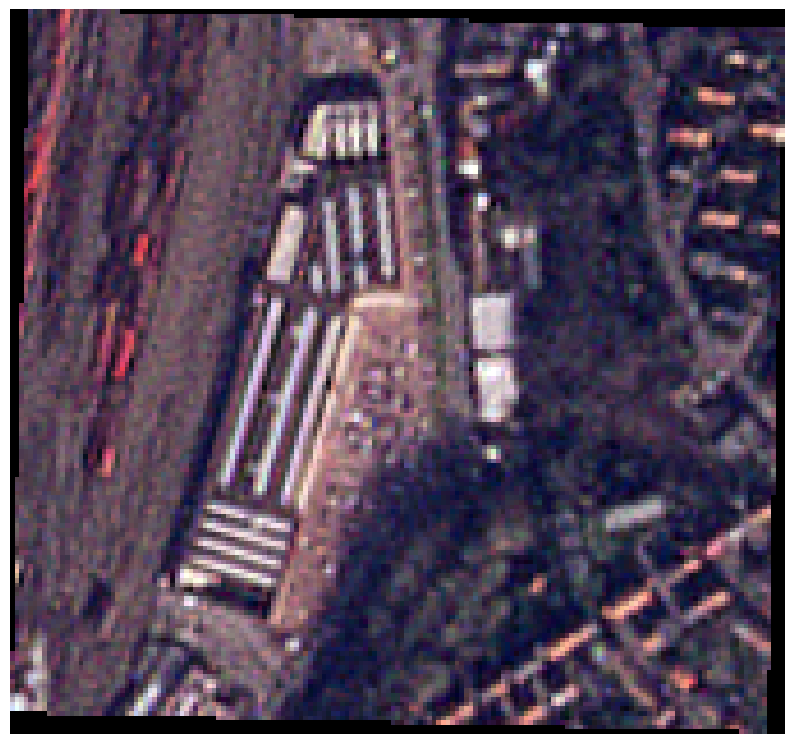

In [24]:
#plot single random image
plt.figure(figsize=(10,10))
img = rioxarray.open_rasterio(clean_3[0])
plt.imshow(img.data[0:3].transpose(1, 2, 0))
plt.axis('off')

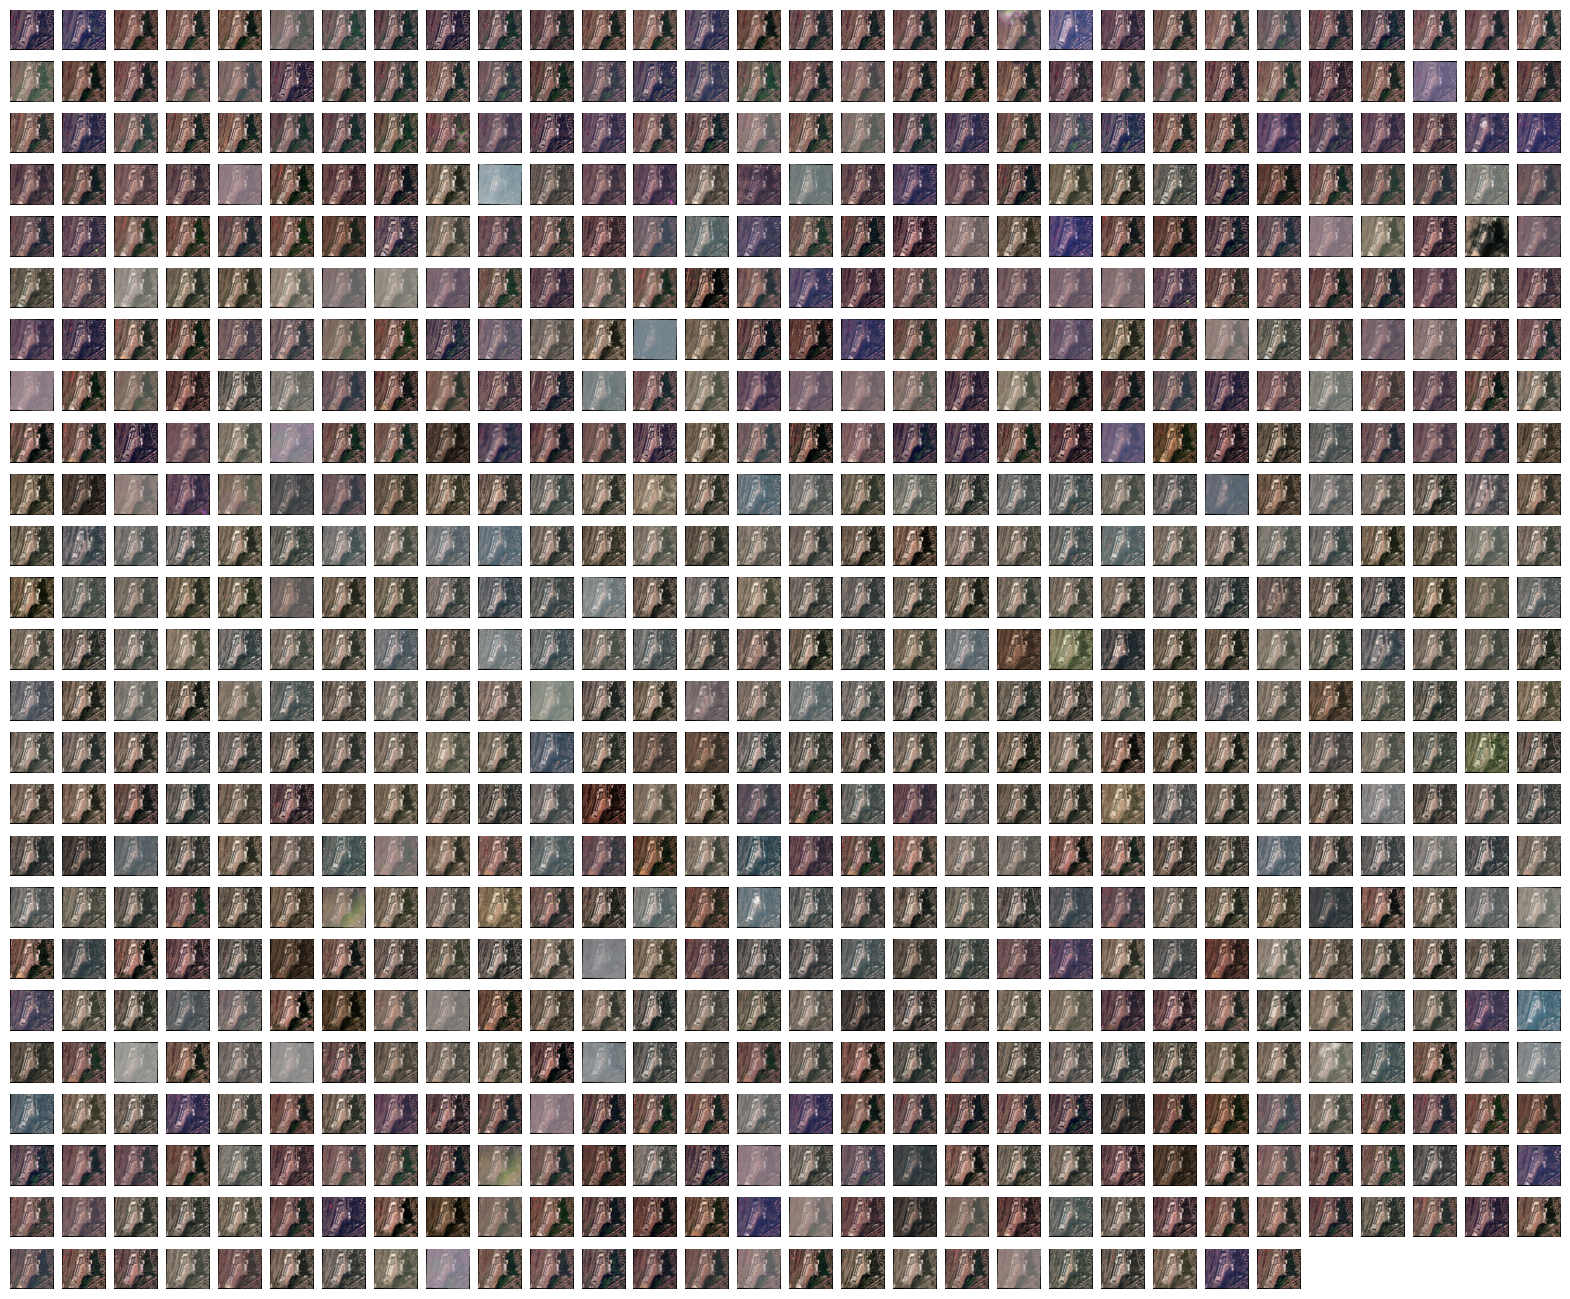

In [23]:
plt.figure(figsize=(20,20))
for i in range(len(clean_3)):
    plt.subplot(30,30,i+1)
    img = rioxarray.open_rasterio(clean_3[i])
    plt.imshow(img.data[0:3].transpose(1, 2, 0))
    plt.axis('off')

In [28]:
#create a dataframe with image path and label
df = label_csv(clean_3)

Class distribution in dataset: 0    652
1     93
Name: label, dtype: int64


In [35]:
#resnet 18 model training after train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import Adam
from tqdm.auto import tqdm
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#train test split
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label.values)
print("Train size:", train.shape)
print("Test size:", test.shape)
#print the class distribution in train and test set
print("Train class distribution:", train.label.value_counts())
print("Test class distribution:", test.label.value_counts())





ImportError: cannot import name '_get_cpp_backtrace' from 'torch._C' (/home/akansh-i2sc/anaconda3/lib/python3.10/site-packages/torch/_C.cpython-310-x86_64-linux-gnu.so)